In [191]:
# IMPORTS
import math
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sbn
import datetime as dt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

In [192]:
# LOAD DATA
start = dt.datetime(2022,4,28)
end = dt.datetime.now()
COINS = ['BTC-USD', 'ETH-USD']
portfolio = [1,3]
prices = yf.download(COINS, start, interval = "30m")
returns = np.log(1+ prices['Adj Close'].pct_change()).dropna()
prices, returns = prices['Adj Close'].to_numpy(), returns.to_numpy()
print(prices.shape)
#print(returns)

[*********************100%***********************]  2 of 2 completed
(297, 2)


In [193]:
price_ratio = np.divide(prices[:,0],prices[:,1])
print(price_ratio.shape)
avg_price_ratio = np.convolve(price_ratio, np.ones(24), 'valid') / 24
print(avg_price_ratio)

(297,)
[13.59780088 13.5968008  13.59556931 13.59274359 13.59155271 13.59067189
 13.59124455 13.59263333 13.59268267 13.59353049 13.59280033 13.59174712
 13.58856771 13.58437401 13.57926623 13.57376085 13.57289303 13.57481509
 13.57557208 13.57645521 13.57839442 13.58066649 13.58252584 13.58307802
 13.58285438 13.58160081 13.58022577 13.58024524 13.5786712  13.57719803
 13.57497239 13.5695144  13.56440294 13.55933585 13.55630001 13.55244133
 13.5502616  13.54990862 13.54956236 13.54965737 13.54864619 13.54681864
 13.54738575 13.54759002 13.5476202  13.54639266 13.54504925 13.5459843
 13.5494593  13.55190847 13.55480184 13.55697498 13.55942716 13.56190586
 13.56451434 13.56937291 13.57497946 13.58043456 13.58547323 13.59094918
 13.59781769 13.60456632 13.61255356 13.62053004 13.62968555 13.63735523
 13.64515504 13.65201375 13.65821411 13.66495211 13.67127276 13.67694489
 13.68059611 13.68500125 13.68829216 13.69162038 13.69411279 13.69559941
 13.69788521 13.70070594 13.70322242 13.70507

cov :  [[0.00039055 0.0005807 ]
 [0.0005807  0.00088226]]


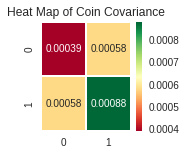

['BTC-USD', 'ETH-USD']


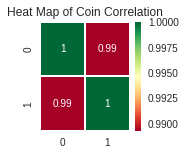

In [194]:
# Takes in cov matrix and returns correlation coeff matrix wz vals e (0, 1)
def correlation_coeffs(cov):
    l = len(cov)
    coeffs = np.zeros((l, l))
    for i in range(l):
        for j in range(l):
            coeffs[i, j] = cov[i, j] / (math.sqrt(cov[i, i]) * math.sqrt(cov[j, j]))
    return coeffs
    
def covariance(coins, start, end):
    # input: coins array, start date, end date
    # output: covariance matrix
    # also prints covariance matrix

    numcoins = len(coins)
    numdays = math.ceil((end - start).days)

    coin_returns = np.zeros((numcoins, numdays))
    for i in range(numcoins):
        data = yf.Ticker(coins[i]).history( interval='1d', start=start , end = end)
        data = np.log(1 + data['Close'].pct_change()).dropna()  # Normalized, interval % return over ~4 months
        coin_returns[i, 0:len(data)] = data

    # Avg returns
    avg_coin_returns = np.zeros(numcoins)
    for coin in range(numcoins):
        sum = 0
        num = 0
        for day in range(numdays):
            retrn = coin_returns[coin, day]
            if retrn != 0:
                sum += retrn
                num += 1
        avg_coin_returns[coin] = sum / num
        # Sample weekly covariances
    cov = np.zeros((numcoins, numcoins))

    for i in range(numcoins):
        for j in range(numcoins):
            sum = 0
            num = 0
            for k in range(numdays):
                xi = coin_returns[i, k]
                yi = coin_returns[j, k]
                # Only calculate covariance at this point if we have data for both asset i and j
                if (xi != 0) and (yi != 0):
                    sum += ( avg_coin_returns[i] - xi ) * ( avg_coin_returns[j] - yi )
                    num += 1
            cov[i, j] = sum / (num-1) # n-1 for sample covariance

    plt.style.use("seaborn")
    print("cov : ",cov)
 
    # 3. Plot correlations heatmap
    plt.figure(figsize=(numcoins,numcoins))
    heat_map = sbn.heatmap( cov, linewidth = 1 , annot = True , cmap = "RdYlGn")
    plt.title( "Heat Map of Coin Covariance" )
    plt.show()
    return cov


start = dt.date(year = 2022, month = 4, day = 28)
end = dt.date.today()
cov = covariance (COINS, start, end)
correlations = correlation_coeffs(cov)
# 3. Plot correlation heatmap
plt.figure(figsize=(len(correlations),len(correlations)))
heat_map = sbn.heatmap( correlations, linewidth = 1 , annot = True , cmap = "RdYlGn")
print(COINS)
plt.title( "Heat Map of Coin Correlation" )
plt.show()

In [195]:
zscores = stats.zscore(price_ratio[23:]-avg_price_ratio)
print(price_ratio)
print(zscores)

[13.59657028 13.59925286 13.62939307 13.63606512 13.63771366 13.61576079
 13.63493539 13.63982786 13.63371626 13.63111903 13.63596379 13.64700205
 13.6399139  13.64991942 13.65419157 13.57509898 13.53193798 13.51774174
 13.53370038 13.53663389 13.54069908 13.54176075 13.54282383 13.54547942
 13.57256842 13.56969697 13.56157599 13.60748394 13.61657393 13.62950451
 13.66826631 13.64101196 13.65406401 13.61359517 13.6106866  13.57069634
 13.53926502 13.52733269 13.52206245 13.55427132 13.57806747 13.5359094
 13.55489549 13.5831751  13.59522855 13.58638522 13.55607625 13.54011197
 13.5424828  13.53669599 13.56204333 13.56970695 13.58121781 13.57608915
 13.53727458 13.51833694 13.53245369 13.54073511 13.51807831 13.51838287
 13.53079337 13.51902254 13.52434276 13.53000282 13.53420636 13.54952008
 13.55979786 13.58389945 13.56576767 13.55414345 13.57851743 13.62351194
 13.60126292 13.60613675 13.61419883 13.62855905 13.64070679 13.63869257
 13.65388037 13.65289407 13.66337604 13.66166332 13.

In [196]:
def buy_sell(unit,zscore, amount_token1, amount_token2):
    pnl = 0
    prev_zscore = 0
    open_pos = False
    pos = (0,0)
    for i in range(len(zscores)-23):
        if ( (prev_zscore >= 2) and (zscore[i] <= 0.75) and (open_pos == True)):
          print("- - - zscore re-enters [-0.75, 0.75], close position - - -")
          print("Sell " +str(pos[1])+" of "+COINS[1])
          amount_token1 -= avg_price_ratio[i]*unit
          print("Buy 1 unit of "+COINS[0])
          amount_token2 += unit
          pnl = pnl + prices[i, 1] * pos[1] + prices[i, 0] * pos[0]
          prev_zscore = 0
          open_pos = False
        if (prev_zscore <= -2 and zscore[i] > -0.75 and open_pos == True):
            print("- - - zscore re-enters [-0.75, 0.75], close position - - -")
            print("Sell 1 unit of "+COINS[0])
            amount_token1 -= unit
            print("Buy "+str(pos[1])+" of "+COINS[1])
            amount_token2 += avg_price_ratio[i]*unit
            pnl = pnl + prices[i, 1] * pos[1] + prices[i, 0] * pos[0]
            prev_zscore = 0
            open_pos = False
        if zscores[i] > 2 and open_pos == False:
            print("- - - zscore > 2 opening- - -")
            print("Buy " +str(avg_price_ratio[i]*unit)+" of "+COINS[1])
            amount_token2 += avg_price_ratio[i]*unit
            print("Sell 1 unit of "+COINS[0])
            amount_token1 -= unit
            pnl = pnl - prices[i, 1] * avg_price_ratio[i] * unit + prices[i, 0] * unit
            prev_zscore = 2
            open_pos = True
            pos = (-unit, avg_price_ratio[i]*unit)
        elif (zscores[i] < -2) and open_pos == False:
            print("- - - zscore < -2 opening- - -")
            print("Buy 1 unit of "+COINS[0])
            amount_token1 += unit
            print("Sell "+str(avg_price_ratio[i]*unit)+" of "+COINS[1])
            amount_token2 -= avg_price_ratio[i]*unit
            pnl = pnl - prices[i, 0] * unit + prices[i, 1] * avg_price_ratio[i] * unit
            prev_zscore = -2
            open_pos = True
            pos = (unit, -avg_price_ratio[i]*unit)
    if open_pos:
        pnl = pnl + prices[i, 1] * pos[1] + prices[i, 0] * pos[0] 
    return (pnl, amount_token1, amount_token2)
  


     
    




ret_val = buy_sell(0.1,stats.zscore(price_ratio[23:]-avg_price_ratio), 10, 5)
print("")
print("")
print("")
print("-------------Final Output--------------")
print("starting amount: " + str(prices[10][0]*10 + prices[10][1]*5))
print("pnl: " + str(ret_val[0])) 
print("amount token1: " + str(ret_val[1])) 
print("amount token2: " + str(ret_val[2]))





- - - zscore > 2 opening- - -
Buy 1.3629685546420225 of ETH-USD
Sell 1 unit of BTC-USD
- - - zscore re-enters [-0.75, 0.75], close position - - -
Sell 1.3629685546420225 of ETH-USD
Buy 1 unit of BTC-USD
- - - zscore > 2 opening- - -
Buy 1.363504805714675 of ETH-USD
Sell 1 unit of BTC-USD
- - - zscore re-enters [-0.75, 0.75], close position - - -
Sell 1.363504805714675 of ETH-USD
Buy 1 unit of BTC-USD
- - - zscore < -2 opening- - -
Buy 1 unit of BTC-USD
Sell 1.3729316566052254 of ETH-USD
- - - zscore re-enters [-0.75, 0.75], close position - - -
Sell 1 unit of BTC-USD
Buy -1.3729316566052254 of ETH-USD



-------------Final Output--------------
starting amount: 407718.7097167969
pnl: 12.663360617028502
amount token1: 7.0624006212153905
amount token2: 7.909754829188801


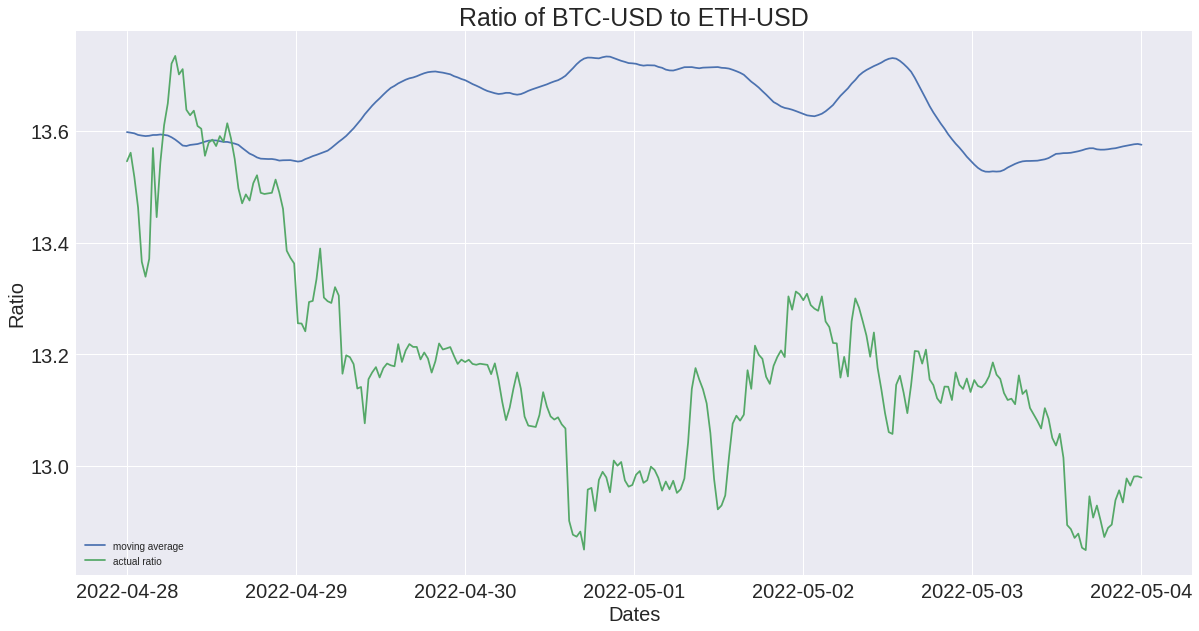

In [197]:
def plot_ratio():
    times = pd.date_range(start, end, periods=274)
    plt.figure(figsize = (20,10))
    plt.plot(times, avg_price_ratio, label="moving average")
    plt.plot(times, prices[23:,0]/prices[23,1], label="actual ratio")
    plt.xticks(fontsize = "20")
    plt.yticks(fontsize = "20")
    plt.xlabel("Dates", fontsize = "20")
    plt.ylabel("Ratio", fontsize = "20")
    plt.title("Ratio of " + COINS[0] + " to " + COINS[1], fontsize = "25")
    plt.legend(loc="lower left")
    plt.show()
    
plot_ratio()

In [198]:
"def graph_ratio(token1, token2):
    mvavg1 = moving_avg(token1)
    mvavg2 = moving_avg(token2)
    ratios = []
    index = 0
    for avg in mvavg1:
        ratios.append(avg/mvavg2[index])
    plt.plot(ratios)
    plt.title('Ratio of ' + token1 + " to " + token2)


SyntaxError: ignored